In [1]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using JLD
using Statistics
using LaTeXStrings

Consider the problem of recovering $x\in\mathbb{R}^n$ from noisy signed compressive measurements of the form

$$y = \text{sign}(Ax) + \epsilon, $$

where $\epsilon\in\mathbb{R}^n$ is noise and $A \in \mathbb{R}^{m\times n}$ is a known sensing matrix. We assume the unknown signal $x$ lives in the range of known a generative model $G:\mathbb{R}^k \rightarrow \mathbb{R}^n$, i.e. $x = G(z)$ for some $z \in \mathbb{R}^k$. We assume the generative model $G$ is  fully-connected feedforward network of the form 

$$ G(x) = \sigma_d(A_d\sigma_{d-1}(A_{d-1} \cdots \sigma_1(A_1 z)\cdots)),$$

where $A_i \in \mathbb{R}^{n_i \times n_{i-1}}$ is the weight matrix and $\sigma_i$ is the activation function correpsonding to the $i\text{th}$ layer of $G$. Thus, the task of recovering $x$ can be reduced to recovering the corresponding $z$ such that $G(z) = x$. 


We solve this problem using the following iterative algorithm called Partially Linearized Updates for Generative Inversion (PLUGIn)-1bit:

$$x^{k+1} = x^k -\eta A_1^{\top}\cdots A_d^{\top}A^{\top}\left(\text{sign}(AG(x^k)) - y \right) .$$

Here, $\eta$ is the stepsize that depends on the weight matrices and the activation functions.

In [2]:
# output the plugin Iterate
function PLUGIN_1bitCS(G, W, A, y, z, stepsize)
    AT = transpose(A)
    WT = transpose(W)
    d = sign.(A * G(z)) - y
    d = AT*d
    d = WT*d
    return z - stepsize * d
end

# output the plugin Iterate
function PLUGIN_CS(G, W, A, y, z, stepsize)
    d = W'*A'* (A * G(z) - y )
    return z - stepsize * d
end

PLUGIN_CS (generic function with 1 method)

In [3]:
function normalized_weight_product(G)
    (_, z_dim) = size(Flux.params(G[1])[1]);
    W = I(z_dim)
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /s[1]
    end
    return W
end  

normalized_weight_product (generic function with 1 method)

In [4]:
function create_network(net_param)
    n_0 = net_param[1]
    n_1 = net_param[2]
    L = Chain(Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))

    for i in 2:length(net_param) - 1
        n_0 = net_param[i]
        n_1 = net_param[i+1]
        L = Chain(L, Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))
    end
    return L
end

create_network (generic function with 1 method)

In [5]:
function k_quantized(z,k)
    return round.((k-1)*z)/(k-1)
end

function scalar_quantizer(z,k,delta)
    if  abs(z) < k*delta/2
        z = delta * floor(z/delta) + delta/2
    else
        z = k*delta/2
    end
    return z
end

function sigma_delta_quant(y, k, delta)
    m = length(y)
    u = zeros(m+1)
    for i in 1:m
        q = scalar_quantizer(y[i] + u[i], k, delta)
        u[i+1] = u[i] + y[i] - q
        y[i] = q
    end
    return y, u
end


# output the plugin Iterate
function PLUGIN_kbitCS_estimate(A, G, W, y, z, k, stepsize)
    d = W'*A'* (k_quantized(A * G(z), k) - y )
    return z - stepsize * d
end

PLUGIN_kbitCS_estimate (generic function with 1 method)

In the first experiment, we want to examine the convergence rate of the PLUGIn-bit algorithm as a function of the number of measurement. Define the recovery error  as:
$$\text{recovery error, $\delta$} := \left\| \tfrac{x^{\natural}}{\|x^\natural\|} - \tfrac{x^*}{\|x^*\|} \right\|,$$
where $x^\natural$ is the recovered estimate of ground truth $x^*$. We hope to see a error decay as $\delta \sim \tfrac{1}{m^\alpha}$ for some $\alpha \in (0,1)$.


The following code segment is used to generate the relationship betwen $\delta$ and $m$.

In [11]:
net_param = [5, 200, 750]
x_dim  = net_param[length(net_param)]
z_dim = net_param[1]

G = create_network(net_param)
    
stepsize = 1
max_iter = 2000
tolerance = 1e-7

W = normalized_weight_product(G)
m_list = 100:2000:50000
trials = 10
recov_error_matrix = zeros(length(m_list))

for trial in 1:trials
    recov_error = []
    z = randn(z_dim)

    for m in m_list
        A = randn(m, x_dim)/sqrt(m)
        y = sign.(A*G(z))
        z_est = zeros(z_dim)
        iter = 1
        succ_error = 1

        while iter <= max_iter && succ_error > tolerance
            z_old = z_est
            z_est = PLUGIN_1bitCS(G, W, A, y, z_est, stepsize)
            succ_error = norm(z_old - z_est, 2)
            iter += 1
        end
        push!(recov_error, norm(z/norm(z) - z_est/norm(z_est)))
    end
    recov_error_matrix = hcat(recov_error_matrix, recov_error)

end

# change the filename before running this code if you wish to save the results

# M = recov_error_matrix[:,2:end]
# save("result/error_1.jld", "error", M, "measurement", m_list, "trials", trials)

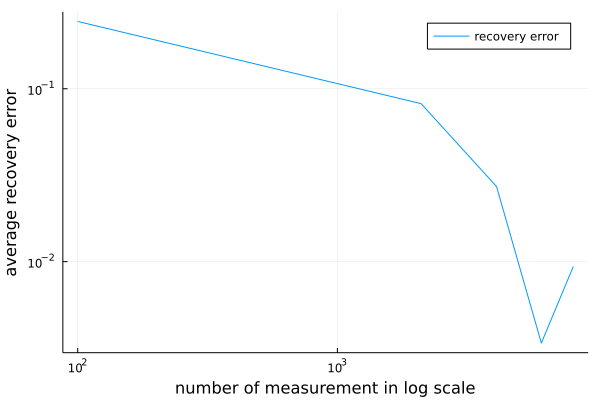

In [10]:
M2 = recov_error_matrix[:,2:end]
average_recov = mean(M2, dims=2)
std_recov = std(M2, dims=2)
# plot(m_list, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 1, label = false)
plot(m_list, average_recov, label = "recovery error", xlabel = "number of measurement in log scale", ylabel = "average recovery error", xaxis=:log, yaxis=:log)
